In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os
import glob


In [10]:
def collect_data_from_csvs(directory_path):
    return glob.glob(os.path.join(directory_path, '*.csv'))


 Charging Part Function

In [11]:
def charging_part(file_path):
    df = pd.read_csv(file_path)
    plt.plot(df.iloc[:,1],df.iloc[:,5])
    df['is_charging'] = df['Command'].str.contains('Charge')  # Identify charging instances
    df['charging_phase'] = (df['is_charging'] & ~df['is_charging'].shift(1).fillna(False)).cumsum()
    
    # Count unique charging cycles
    num_charging_cycles = df[df['is_charging']]['charging_phase'].nunique()
    print(f"Number of charging cycles: {num_charging_cycles}")
    
    charging_data = df[df['is_charging']].copy()
    charging_data['deltaV'] = charging_data.groupby('charging_phase')['U'].diff()
    charging_data['deltaAh'] = charging_data.groupby('charging_phase')['Ah'].diff()
    charging_data['dAh/dV'] = np.where(charging_data['deltaV'] != 0, charging_data['deltaAh'] / charging_data['deltaV'], np.nan)
    
    plt.figure(figsize=(10, 8))
    for phase in charging_data['charging_phase'].unique():
        phase_data = charging_data[charging_data['charging_phase'] == phase]
        plt.plot(phase_data['U'], phase_data['dAh/dV'], label=f'Phase {phase}')
    
    plt.xlabel('Voltage (U)')
    plt.ylabel('Incremental capacity [dAh/dV]')
    plt.title('IC curve')
    plt.legend()
    plt.show()

    return df, num_charging_cycles


In [19]:
def plot_charging_phase(df, phase_number):
    phase_data = df[df['charging_phase'] == phase_number]
    if not phase_data.empty:
        plt.figure(figsize=(10, 5))
        plt.plot(phase_data['DataSet'], phase_data['U'], label='Voltage (U)')
        plt.plot(phase_data['DataSet'], phase_data['Ah'], label='Capacity (Ah)')
        plt.xlabel('Dataset')
        plt.ylabel('[U]/[Ah]')
        plt.title(f'Voltage and Capacity during Charging Phase {phase_number}')
        plt.legend()
        plt.show()
    else:
        print(f"No data available for charging phase {phase_number}.")


Number of charging cycles: 7


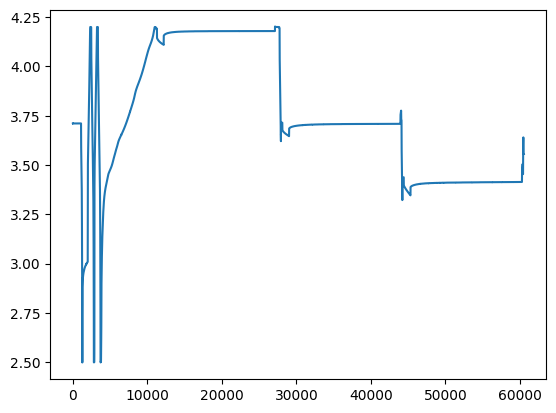

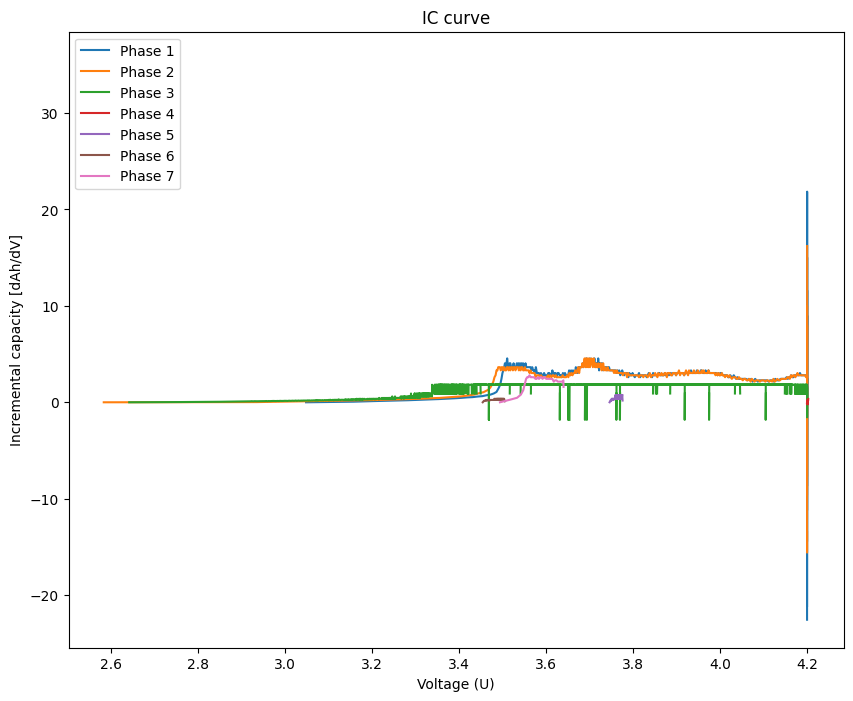

The dataset contains 7 charging cycles.


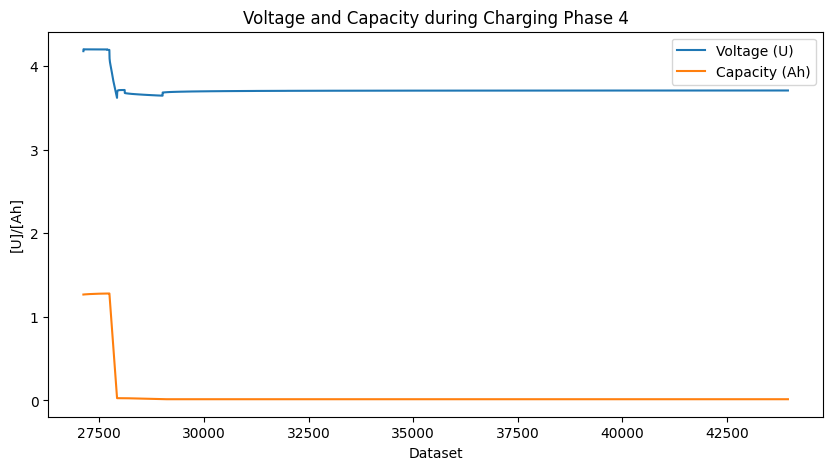

In [21]:
def main():
    # Note: You will need to replace the file_path with a valid path on your system
    file_path = 'E:\Thesis CEVT\Dataset\TUM\CU_Cyclic\CU000_cyc\CU_cyc000csv\extracted_BW-VTC-210_2228_CU_cyc_000_BW-VTC-CYC.csv'
    df, num_charging_cycles = charging_part(file_path)
    print(f"The dataset contains {num_charging_cycles} charging cycles.")
    phase_number = 4  
    plot_charging_phase(df, phase_number)

if __name__ == "__main__":
    main()
